<a href="https://colab.research.google.com/github/Gnanasai1205/VRSU/blob/main/LAB5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total number of images: 1797
Total number of labels: 1797
SVM training completed.
Model Accuracy: 0.8027777777777778


Saving images.png to images (1).png


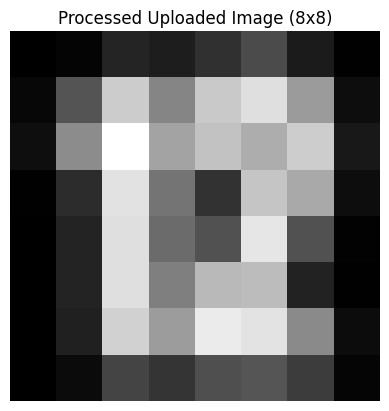

Predicted Digit: 8


In [2]:
# Classical ML based Object Recognition (Digits)

import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from skimage.feature import hog
from skimage.transform import resize
from skimage.color import rgb2gray

# --------------------------------------------------
# 1. LOAD DATASET
# --------------------------------------------------
digits = datasets.load_digits()
X = digits.images
y = digits.target

print("Total number of images:", X.shape[0])
print("Total number of labels:", y.shape[0])

# --------------------------------------------------
# 2. HOG FEATURE EXTRACTION FOR TRAINING DATA
# --------------------------------------------------
features = []

for img in X:
    hog_feature = hog(
        img,
        pixels_per_cell=(4, 4),
        cells_per_block=(1, 1),
        orientations=9
    )
    features.append(hog_feature)

features = np.array(features)

# --------------------------------------------------
# 3. TRAIN–TEST SPLIT
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.2, random_state=42
)

# --------------------------------------------------
# 4. TRAIN SVM MODEL
# --------------------------------------------------
model = SVC(kernel='linear', C=10)
model.fit(X_train, y_train)

print("SVM training completed.")

# --------------------------------------------------
# 5. EVALUATION
# --------------------------------------------------
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

# --------------------------------------------------
# 6. UPLOAD IMAGE (COLAB)
# --------------------------------------------------
from google.colab import files
uploaded = files.upload()

for file_name in uploaded.keys():
    img = cv2.imread(file_name)

# --------------------------------------------------
# 7. IMAGE PREPROCESSING (VERY IMPORTANT)
# --------------------------------------------------

# Convert to grayscale
if len(img.shape) == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    img_gray = img

# Resize to 8x8
img_resized = resize(img_gray, (8, 8), anti_aliasing=True)

# Normalize to 0–16 (same as digits dataset)
img_resized = img_resized / img_resized.max()
img_resized = img_resized * 16

# Invert image (digits dataset: white digit on black bg)
img_resized = 16 - img_resized

# --------------------------------------------------
# 8. DISPLAY PROCESSED IMAGE
# --------------------------------------------------
plt.imshow(img_resized, cmap='gray')
plt.title("Processed Uploaded Image (8x8)")
plt.axis('off')
plt.show()

# --------------------------------------------------
# 9. HOG FEATURE FOR TEST IMAGE
# --------------------------------------------------
test_feature = hog(
    img_resized,
    pixels_per_cell=(4, 4),
    cells_per_block=(1, 1),
    orientations=9
)

# --------------------------------------------------
# 10. PREDICTION
# --------------------------------------------------
prediction = model.predict([test_feature])
print("Predicted Digit:", prediction[0])


CNN Accuracy: 0.9777777791023254


Saving images.png to images (3).png


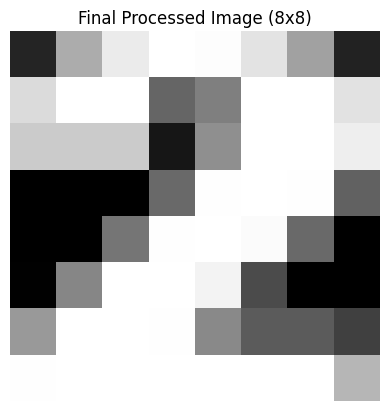

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Predicted Digit: 2


In [6]:
# CNN Digit Recognition (FIXED & RELIABLE)

import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn import datasets
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# -------------------------------
# 1. LOAD DATASET
# -------------------------------
digits = datasets.load_digits()
X = digits.images / 16.0
y = digits.target

X = X.reshape(-1, 8, 8, 1)
y = to_categorical(y, 10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------
# 2. BUILD CNN
# -------------------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(8,8,1)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print("CNN Accuracy:", acc)

# -------------------------------
# 3. UPLOAD IMAGE
# -------------------------------
from google.colab import files
uploaded = files.upload()

for fname in uploaded:
    img = cv2.imread(fname)

# -------------------------------
# 4. STRONG PREPROCESSING
# -------------------------------
# Grayscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Blur + Threshold
img = cv2.GaussianBlur(img, (5,5), 0)
_, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours and crop digit
contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
img = img[y:y+h, x:x+w]

# Resize to 8x8
img = cv2.resize(img, (8,8), interpolation=cv2.INTER_AREA)

# Normalize
img = img / 255.0

# Reshape
img = img.reshape(1,8,8,1)

# Show processed image
plt.imshow(img.reshape(8,8), cmap='gray')
plt.title("Final Processed Image (8x8)")
plt.axis('off')
plt.show()

# -------------------------------
# 5. PREDICTION
# -------------------------------
pred = np.argmax(model.predict(img))
print("Predicted Digit:", pred)
